# Dataset

### Data collection

- "dataset/0"
- "dataset/1"
- "dataset/2"

### Traitement des données

In [1]:
import torchvision.transforms as tf
import torch

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transforms = tf.Compose([
    tf.ConvertImageDtype(torch.float32),
    tf.RandomRotation(180),
    tf.RandomResizedCrop(224, scale=(0.6, 1.0)),
    tf.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    tf.Normalize(mean=MEAN, std=STD)
])

val_transforms = tf.Compose([
    tf.ConvertImageDtype(torch.float32),
    tf.CenterCrop(224),
    tf.Normalize(mean=MEAN, std=STD)
])


### Data loaders


In [2]:
import numpy as np
import os
import math
from dbd.datasets.datasetLoader import DBD_dataset, _parse_dbd_datasetfolder

def get_dataloaders(root_dataset_path, batch_size=32, seed=42, num_workers=1):
    assert os.path.exists(root_dataset_path)

    # Get the dataset as a list of pairs {image_path, class}
    dataset = _parse_dbd_datasetfolder(root_dataset_path)  # shape is (nb_images, 2)

    # Shuffle dataset and split into a training set and a validation set
    generator = np.random.default_rng(seed)
    generator.shuffle(dataset)

    nb_samples_train = math.floor(0.8 * len(dataset))
    dataset_train, dataset_val = dataset[:nb_samples_train], dataset[nb_samples_train:]

    # Set data loaders
    dataset_train = DBD_dataset(dataset_train, train_transforms)
    dataloader_train = dataset_train.get_dataloader(batch_size=batch_size, num_workers=num_workers, use_balanced_sampler=True)

    dataset_val = DBD_dataset(dataset_val, val_transforms)
    dataloader_val = dataset_val.get_dataloader(batch_size=batch_size, num_workers=num_workers, use_balanced_sampler=False)

    return dataloader_train, dataloader_val


DATASET_ROOT = "dataset/"
dataloader_train, dataloader_val = get_dataloaders(DATASET_ROOT, batch_size=16, num_workers=8)

Parsing folder 0 : 13105 images found
Parsing folder 1 : 11713 images found
Parsing folder 2 : 2665 images found


### Visualize the dataset


input shape is torch.Size([16, 3, 224, 224])
label shape is torch.Size([16])


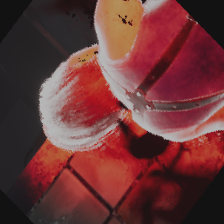

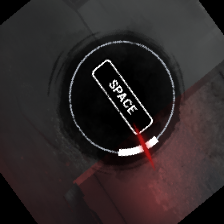

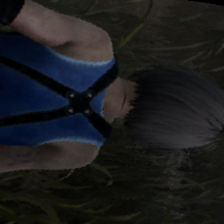

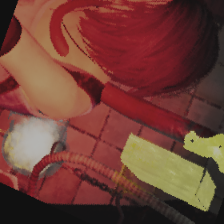

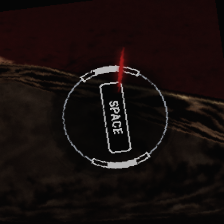

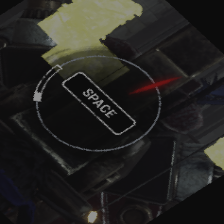

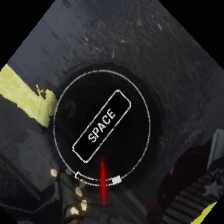

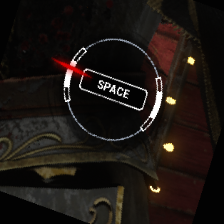

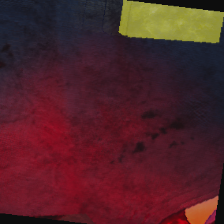

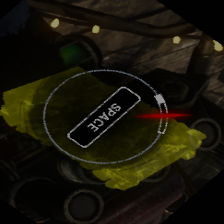

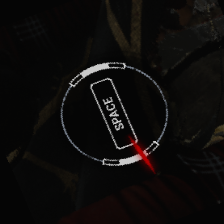

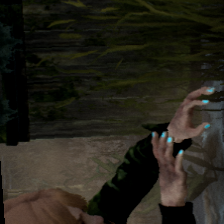

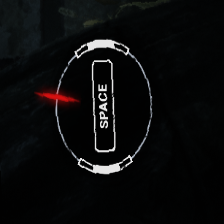

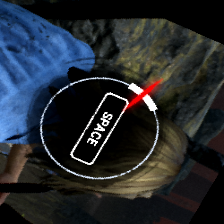

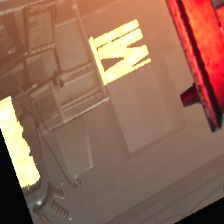

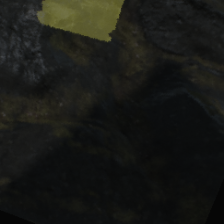

In [3]:
from IPython.display import Image
from PIL import Image

std = torch.tensor(STD, dtype=torch.float32).reshape((1, 3, 1, 1))
mean = torch.tensor(MEAN, dtype=torch.float32).reshape((1, 3, 1, 1))

batch = next(iter(dataloader_train))
x, y = batch

print("input shape is {}".format(x.shape))
print("label shape is {}".format(y.shape))

# inverse of transforms for visualization only
x = x * std + mean  # un-normalization to [0, 1] with auto-broadcast
x = x * 255.

x = x.permute((0, 2, 3, 1))  # to channel last : (N, 3, 224, 224) --> (N, 224, 224, 3)
x = x.cpu().numpy().astype(np.uint8)

for img in x:
    img = Image.fromarray(img, "RGB")
    display(img)


# Architecture

In [4]:
import pytorch_lightning as pl
import torchmetrics
import torch
import torchvision.models as models

class Model(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.example_input_array = torch.zeros((32, 3, 224, 224), dtype=torch.float32)

        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.lr = lr

        self.metrics_train = torchmetrics.MetricCollection([
            torchmetrics.Precision(task='multiclass', num_classes=3, average=None),
            torchmetrics.Recall(task='multiclass', num_classes=3, average=None)
        ])

        self.metrics_val = torchmetrics.MetricCollection([
            torchmetrics.Precision(task='multiclass', num_classes=3, average=None),
            torchmetrics.Recall(task='multiclass', num_classes=3, average=None)
        ])

    def build_encoder(self):
        weights = models.MobileNet_V3_Large_Weights.DEFAULT
        encoder = models.mobilenet_v3_large(weights=weights)
        
        return encoder

    def build_decoder(self):
        return torch.nn.Sequential(
            torch.nn.Linear(1000, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 3),
            # torch.nn.Softmax()  # Use logits instead
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)

        loss = torch.nn.functional.cross_entropy(pred, y)

        self.log("loss/train", loss)
        self.metrics_train.update(pred, y)
        return loss

    def on_train_epoch_end(self):
        results = self.metrics_train.compute()
        pres_0, pres_1, pres_2 = torch.unbind(results['MulticlassPrecision'])
        rec_0, rec_1, rec_2 = torch.unbind(results['MulticlassRecall'])
        self.log_dict({
            'pres/train_0': pres_0, 'pres/train_1': pres_1, 'pres/train_2': pres_2,
            'rec/train_0': rec_0, 'rec/train_1': rec_1, 'rec/train_2': rec_2
        })

        self.metrics_train.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)

        loss = torch.nn.functional.cross_entropy(pred, y)

        self.log("loss/val", loss)
        self.metrics_val.update(pred, y)
        return loss

    def on_validation_epoch_end(self):
        results = self.metrics_val.compute()
        pres_0, pres_1, pres_2 = torch.unbind(results['MulticlassPrecision'])
        rec_0, rec_1, rec_2 = torch.unbind(results['MulticlassRecall'])
        self.log_dict({
            'pres/val_0': pres_0, 'pres/val_1': pres_1, 'pres/val_2': pres_2,
            'rec/val_0': rec_0, 'rec/val_1': rec_1, 'rec/val_2': rec_2
        })

        self.metrics_val.reset()

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        pred = self(x)
        pred = torch.argmax(pred, dim=-1)
        return pred

    def forward(self, x):
        z = self.encoder(x)
        pred = self.decoder(z)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


# Training

### Model loading
Initialisation from scratch

In [5]:
model = Model(lr=1e-4)

From a custom checkpoint

In [8]:
import pytorch_lightning as pl
import glob

checkpoint = "./lightning_logs/mobilenet_v3/checkpoints"
checkpoint = glob.glob(os.path.join(checkpoint, "*.ckpt"))[-1]
model = Model.load_from_checkpoint(checkpoint, strict=True, lr=1e-4)


### Checking the model
Summary

In [6]:
from pytorch_lightning.utilities.model_summary import ModelSummary
summary = ModelSummary(model, max_depth=2)
print(summary)

   | Name                              | Type                | Params | In sizes          | Out sizes      
-----------------------------------------------------------------------------------------------------------------
0  | encoder                           | MobileNetV3         | 5.5 M  | [32, 3, 224, 224] | [32, 1000]     
1  | encoder.features                  | Sequential          | 3.0 M  | [32, 3, 224, 224] | [32, 960, 7, 7]
2  | encoder.avgpool                   | AdaptiveAvgPool2d   | 0      | [32, 960, 7, 7]   | [32, 960, 1, 1]
3  | encoder.classifier                | Sequential          | 2.5 M  | [32, 960]         | [32, 1000]     
4  | decoder                           | Sequential          | 1.0 M  | [32, 1000]        | [32, 3]        
5  | decoder.0                         | Linear              | 1.0 M  | [32, 1000]        | [32, 1000]     
6  | decoder.1                         | ReLU                | 0      | [32, 1000]        | [32, 1000]     
7  | decoder.2        

Check initial validation score

In [9]:
valid = pl.Trainer(accelerator='gpu', devices=1, logger=False)
valid.validate(model=model, dataloaders=dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                    | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        loss/val           0.022557731717824936
       pres/val_0                   1.0
       pres/val_1           0.9995819330215454
       pres/val_2            0.984644889831543
        rec/val_0           0.9996131658554077
        rec/val_1           0.9966652989387512
        rec/val_2                   1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'loss/val': 0.022557731717824936,
  'pres/val_0': 1.0,
  'pres/val_1': 0.9995819330215454,
  'pres/val_2': 0.984644889831543,
  'rec/val_0': 0.9996131658554077,
  'rec/val_1': 0.9966652989387512,
  'rec/val_2': 1.0}]

### Training

In [ ]:
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=1000, num_sanity_val_steps=0)
trainer.fit(model=model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_val)

# Deployment and inference
### ONNX model deployment
Why : 
- optimized inference
- interop

In [11]:
filepath = "model.onnx"
input_sample = torch.zeros((1, 3, 224, 224), dtype=torch.float32)
model.to_onnx(filepath, input_sample, export_params=True)

### Final demo
Save images with great skill check

Monitoring the screen...


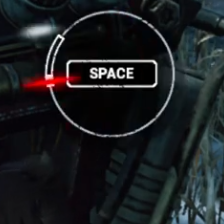

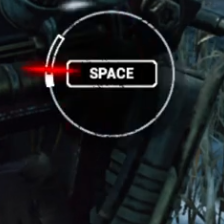

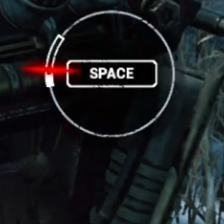

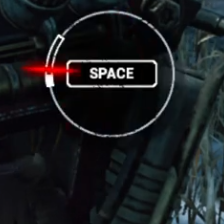

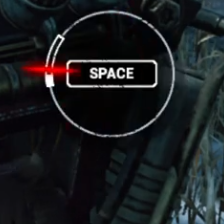

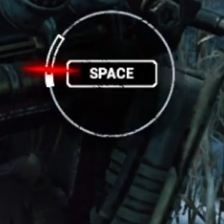

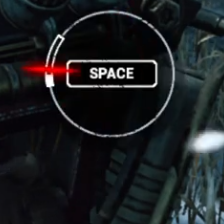

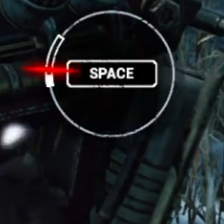

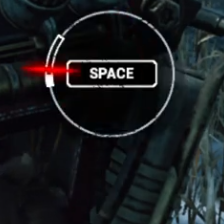

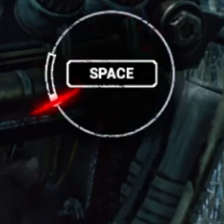

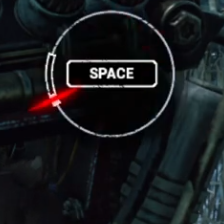

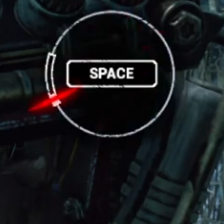

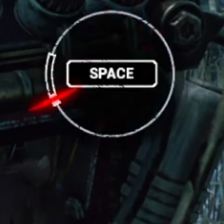

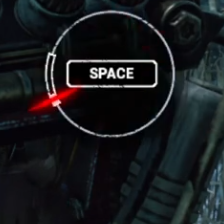

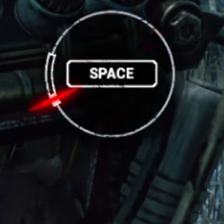

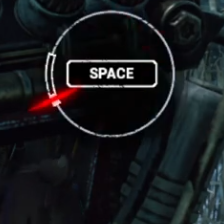

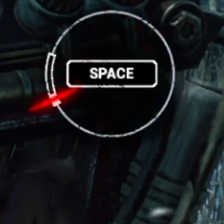

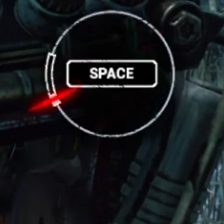

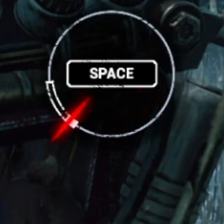

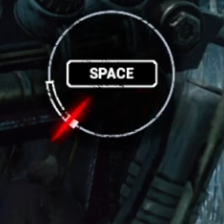

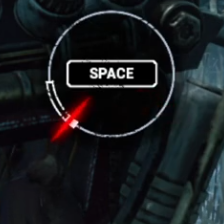

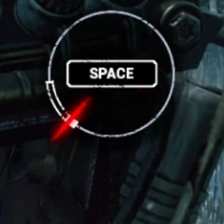

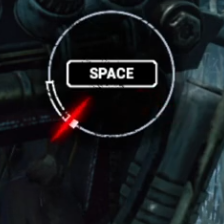

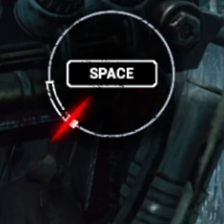

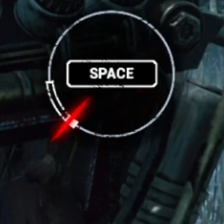

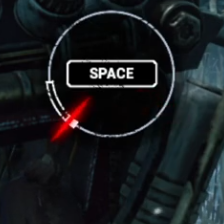

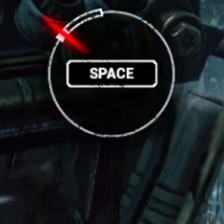

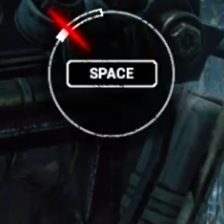

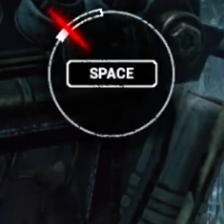

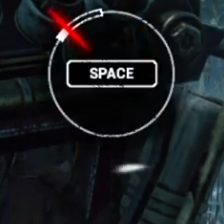

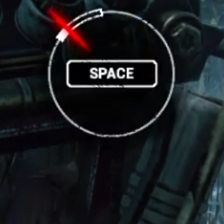

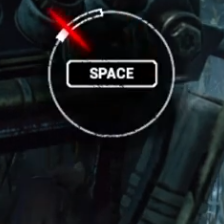

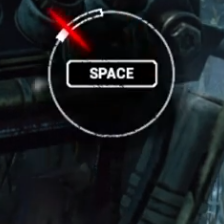

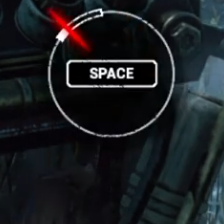

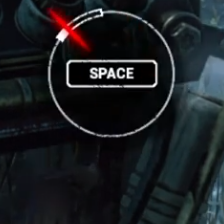

KeyboardInterrupt: 

In [12]:
import mss
import onnxruntime
from IPython.display import clear_output

from dbd.utils.frame_grabber import get_monitor_attributes_test

def screenshot_to_numpy(screenshot):
    img = np.array(screenshot, dtype=np.float32)
    img = np.flip(img[:, :, :3], 2)
    img = img / 255.0
    img = (img - MEAN) / STD

    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)

    img = np.float32(img)
    return img

# Get monitor attributes to grab frames
monitor = get_monitor_attributes_test()

ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name

with mss.mss() as sct:
    print("Monitoring the screen...")
    while True:
        screenshot = sct.grab(monitor)
        img = screenshot_to_numpy(screenshot)

        ort_inputs = {input_name: img}
        ort_outs = ort_session.run(None, ort_inputs)
        pred = np.argmax(np.squeeze(ort_outs, 0))

        # Hit !!
        if pred == 2:
            # PressKey(SPACE)
            # ReleaseKey(SPACE)

            img = Image.frombytes("RGB", screenshot.size, screenshot.bgra, "raw", "BGRX")
            display(img)
